In [1]:
from tensorflow.keras import models, layers, utils, losses, optimizers
import numpy as np

def load_data(cpath):
    a = np.load(cpath)
    cdata = a['data']
    clabel = a['label']
    return cdata, clabel

def network():
    # 模型建立
    # 两层3x3窗口的卷积(卷积核数为32和64)，一层最大池化(MaxPooling2D)
    # 再Dropout(随机屏蔽部分神经元)并一维化(Flatten)到128个单元的全连接层(Dense)，最后Dropout输出到36个单元的全连接层（全部字符为36个）
    model = models.Sequential()
    model.add(layers.Conv2D(32,
                            kernel_size=(3, 3),
                            activation='relu',
                            input_shape=input_shape))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPool2D(pool_size=(2, 2)))
    model.add(layers.Dropout(0.25))  # 随机屏蔽部分神经元
    model.add(layers.Flatten())  # 一维化
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(num_classes, activation='softmax'))

    # 模型编译
    model.compile(loss=losses.categorical_crossentropy,
                  optimizer=optimizers.Adadelta(),
                  metrics=['accuracy'])
    
    return model

In [2]:
import string

path = 'train_pictures/data_label.npz'
CHRS = string.ascii_lowercase + string.digits  # 小写字母+数字
num_classes = len(CHRS)  # 分类数
input_shape = (22, 13, 1)
batch_size = 128
epochs = 12

X, Y = load_data(path)
Y = utils.to_categorical(Y, num_classes)  # 对Y进行one-hot编码
X = X.reshape(X.shape[0], *input_shape)
# 简单的切分出训练集和测试集
split_point = len(Y) - 500
x_train, y_train, x_test, y_test = X[:split_point], Y[:split_point], X[split_point:], Y[split_point:]

model = network()
history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(x_test, y_test))

Train on 8560 samples, validate on 500 samples
Epoch 1/12
8560/8560 [==============================] - 13s 2ms/step - loss: 2.0542 - acc: 0.4089 - val_loss: 0.3615 - val_acc: 0.9160
Epoch 2/12
8560/8560 [==============================] - 10s 1ms/step - loss: 0.3849 - acc: 0.8797 - val_loss: 0.0512 - val_acc: 0.9940
Epoch 3/12
8560/8560 [==============================] - 11s 1ms/step - loss: 0.1687 - acc: 0.9514 - val_loss: 0.0236 - val_acc: 0.9960
Epoch 4/12
8560/8560 [==============================] - 9s 1ms/step - loss: 0.1094 - acc: 0.9703 - val_loss: 0.0123 - val_acc: 0.9980
Epoch 5/12
8560/8560 [==============================] - 13s 2ms/step - loss: 0.0798 - acc: 0.9790 - val_loss: 0.0103 - val_acc: 0.9960
Epoch 6/12
8560/8560 [==============================] - 11s 1ms/step - loss: 0.0703 - acc: 0.9825 - val_loss: 0.0098 - val_acc: 0.9980
Epoch 7/12
8560/8560 [==============================] - 9s 1ms/step - loss: 0.0586 - acc: 0.9863 - val_loss: 0.0051 - val_acc: 0.9980
Epoch 8/12

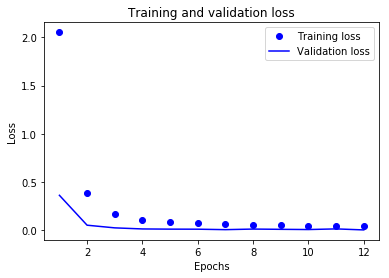

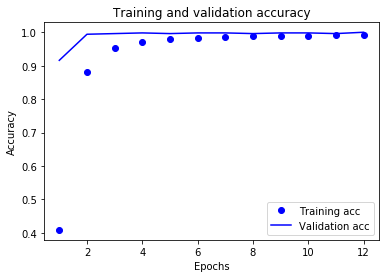

In [4]:
import matplotlib.pyplot as plt

history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']

epochs = range(1, len(loss_values) + 1)

plt.figure(1)
plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

acc = history_dict['acc']
val_acc = history_dict['val_acc']

plt.figure(2)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [6]:
# 保存模型
model.save('verification_code_model.h5')

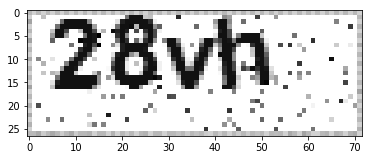

result:  28vh


In [3]:
# 预测展示
from tensorflow.keras.models import load_model
import string
import numpy as np
import cv2
import matplotlib.pyplot as plt

CHRS = string.ascii_lowercase + string.digits  # 小写字母+数字
split_lines = [4, 16, 28, 40, 52]  # 验证码纵向切分的位置
y_min, y_max = 0, 22  # 验证码横向切分的位置
input_shape = (22, 13, 1)

model_path = 'verification_code_model.h5'
img_path = '28vh.png'

cnn_model = load_model(model_path)

image = cv2.imread(img_path)
gray_img = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)  # 灰度化
ims = [gray_img[y_min:y_max, u:v + 1] for u, v in zip(split_lines[:-1], split_lines[1:])]  # 切分验证码

name = ''
for i in range(len(ims)):
    test_input = 1.0 * np.array(ims[i])  # 图片转化为矩阵
    test_input = test_input.reshape(1, *input_shape)  # reshape多出来一个1因为预测的时候只有一个样本
    y_probs = cnn_model.predict(test_input)  # 模型预测, y_probs的形状为(1, 36)
    name += CHRS[y_probs[0].argmax(axis=0)]

plt.imshow(gray_img, 'gray')
plt.show()
print('result: ', name)